In [1]:
import pandas as pd
from sklearn.impute import KNNImputer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, make_scorer, PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/Fraud_Detection_Dataset.csv')

In [3]:
# Display basic information
print(df.shape)
print(df.columns)
print(df.info())
print(df.head())
print(df.tail())

(10000, 10)
Index(['Transaction ID', 'Customer ID', 'Transaction Amount',
       'Transaction Date and Time', 'Merchant Category', 'Location',
       'Previous Transaction Amount', 'Time Since Last Transaction',
       'Device Type', 'Fraud'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Transaction ID               10000 non-null  int64  
 1   Customer ID                  10000 non-null  int64  
 2   Transaction Amount           10000 non-null  float64
 3   Transaction Date and Time    10000 non-null  object 
 4   Merchant Category            10000 non-null  object 
 5   Location                     10000 non-null  object 
 6   Previous Transaction Amount  10000 non-null  float64
 7   Time Since Last Transaction  10000 non-null  float64
 8   Device Type                  10000 non-nu

In [4]:
# Check for any missing values in the DataFrame
missing_values = df.isnull().sum()

# Display the missing values
missing_values

Transaction ID                 0
Customer ID                    0
Transaction Amount             0
Transaction Date and Time      0
Merchant Category              0
Location                       0
Previous Transaction Amount    0
Time Since Last Transaction    0
Device Type                    0
Fraud                          0
dtype: int64

In [5]:
# Convert 'fraud' to 1 or 0
df['Fraud'] = np.where(df['Fraud'] == 'Yes', 1, 0)

In [10]:
# Convert date columns to datetime
df['Transaction Date and Time'] = pd.to_datetime(df['Transaction Date and Time'])

In [11]:
df.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,Los Angeles,579.323704,481.377516,desktop,0
1,2,4507,474.046452,2023-01-01 00:01:00,Dining,Houston,407.220271,1159.211075,desktop,0
2,3,1860,498.819570,2023-01-01 00:02:00,Dining,San Francisco,265.583605,720.677284,desktop,0
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,Los Angeles,1097.259081,1.000000,mobile,0
4,5,2130,279.181247,2023-01-01 00:04:00,Electronics,Los Angeles,238.389682,1378.958721,mobile,0


In [12]:
df.describe()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Previous Transaction Amount,Time Since Last Transaction,Fraud
count,10000.00000,10000.000000,10000.000000,10000,10000.000000,10000.000000,10000.000000
mean,5000.50000,3010.561100,559.865608,2023-01-04 11:19:30,461.410984,677.040726,0.139200
min,1.00000,1000.000000,1.000000,2023-01-01 00:00:00,0.000000,1.000000,0.000000
25%,2500.75000,2001.750000,262.969956,2023-01-02 17:39:45,181.109688,295.523894,0.000000
50%,5000.50000,3004.000000,522.370941,2023-01-04 11:19:30,404.367010,653.143168,0.000000
75%,7500.25000,4010.000000,788.415931,2023-01-06 04:59:15,676.079655,1048.479972,0.000000
max,10000.00000,4999.000000,2953.394492,2023-01-07 22:39:00,1500.000000,1694.715674,1.000000
std,2886.89568,1152.371939,399.984400,NaN,334.582413,432.386769,0.346172


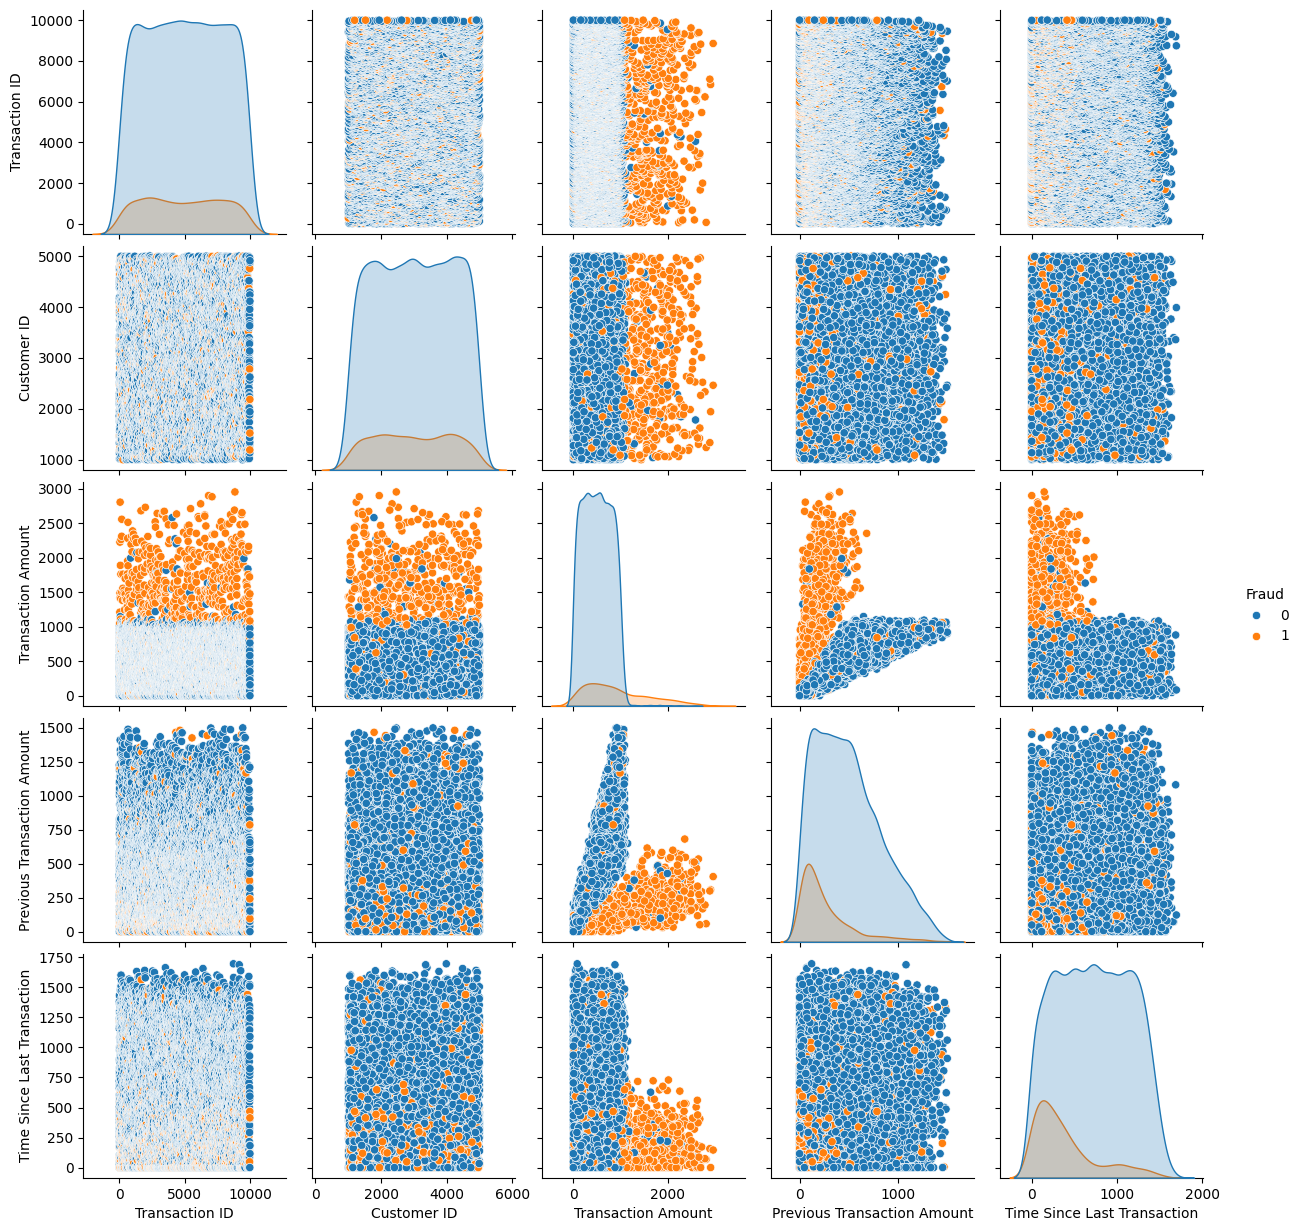

In [13]:
# pairplot
sns.pairplot(df, hue='Fraud')

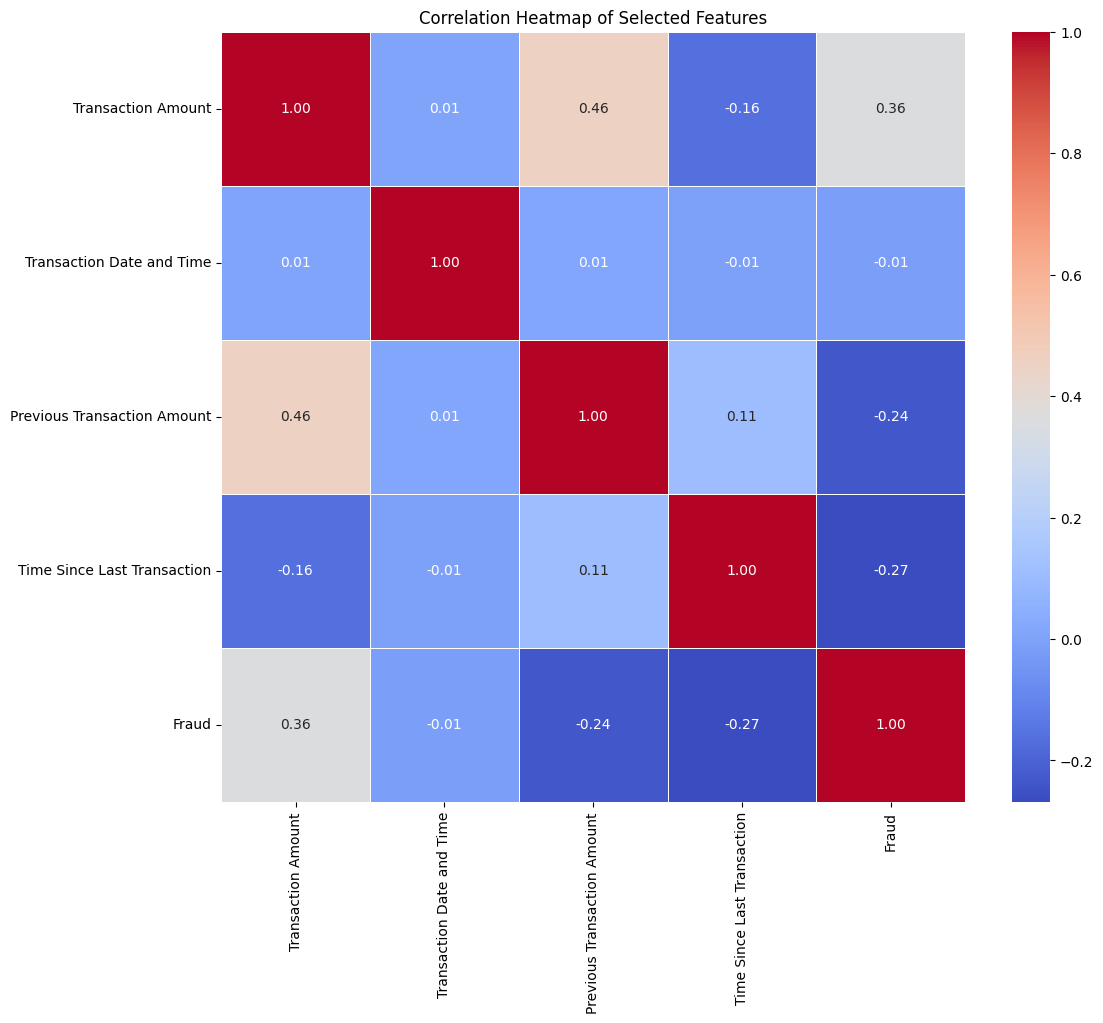

In [14]:
# heatmap
# Include only numeric features and the target variable
numeric_features = ['Transaction Amount', 'Transaction Date and Time', 
       'Previous Transaction Amount', 'Time Since Last Transaction',
       'Fraud']

# Calculate the correlation matrix
corr_matrix = df[numeric_features].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Selected Features')
plt.show()


In [27]:
from scipy.stats import ttest_ind

# Define the numeric features and the target variable
numeric_features = ['Transaction Amount', 'Time Since Last Transaction',
                    'Previous Transaction Amount']
target = 'Fraud'

# Ensure 'Fraud' is binary and convert to integer type
df[target] = df[target].astype(int)

# Perform t-tests for each numeric feature
t_test_results = {}
for feature in numeric_features:
    no_fraud = df[df[target] == 0][feature]
    yes_fraud = df[df[target] == 1][feature]
    t_stat, p_value = ttest_ind(no_fraud, yes_fraud, equal_var=False)
    t_test_results[feature] = (t_stat, p_value)

# Display the results
t_test_results

{'Transaction Amount': (-22.903247525251736, 1.2212097932148008e-99),
 'Time Since Last Transaction': (30.80421715932078, 2.153793101448487e-171),
 'Previous Transaction Amount': (27.70538944496681, 3.637687769574471e-144)}

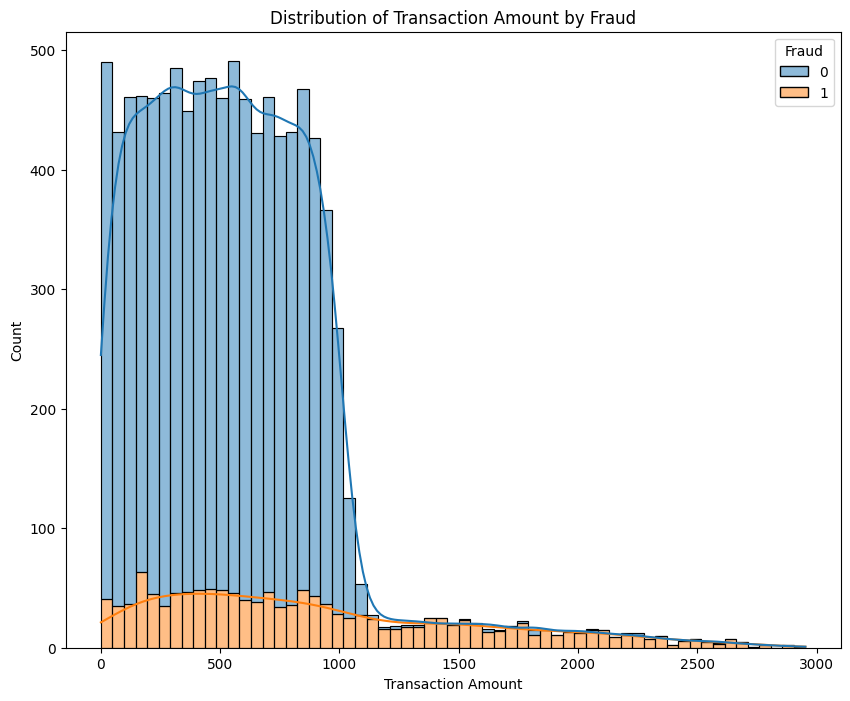

In [28]:
plt.figure(figsize=(10, 8))
sns.histplot(data=df, x='Transaction Amount', hue='Fraud', multiple='stack', kde=True)
plt.title('Distribution of Transaction Amount by Fraud')
plt.show()

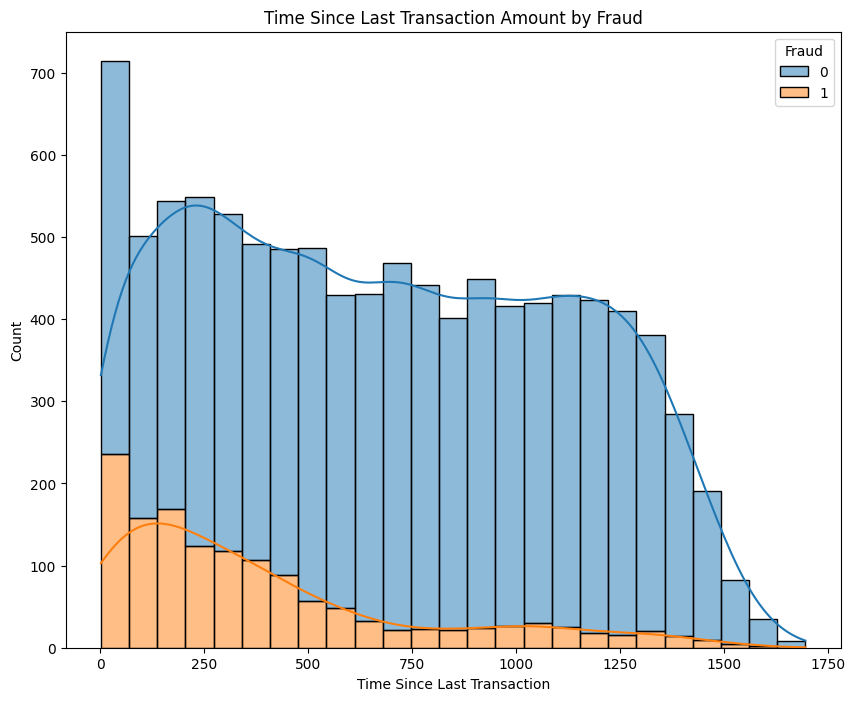

In [29]:
plt.figure(figsize=(10, 8))
sns.histplot(data=df, x='Time Since Last Transaction', hue='Fraud', multiple='stack', kde=True)
plt.title('Time Since Last Transaction Amount by Fraud')
plt.show()

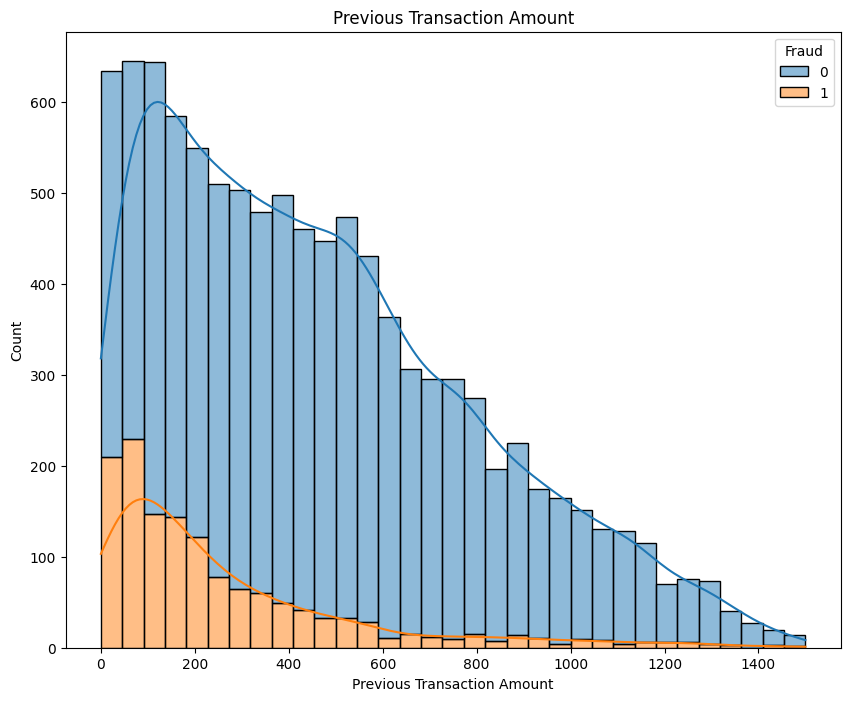

In [30]:
plt.figure(figsize=(10, 8))
sns.histplot(data=df, x='Previous Transaction Amount', hue='Fraud', multiple='stack', kde=True)
plt.title('Previous Transaction Amount')
plt.show()

In [34]:
print(df.columns)

Index(['Transaction ID', 'Customer ID', 'Transaction Amount',
       'Transaction Date and Time', 'Merchant Category', 'Location',
       'Previous Transaction Amount', 'Time Since Last Transaction',
       'Device Type', 'Fraud'],
      dtype='object')


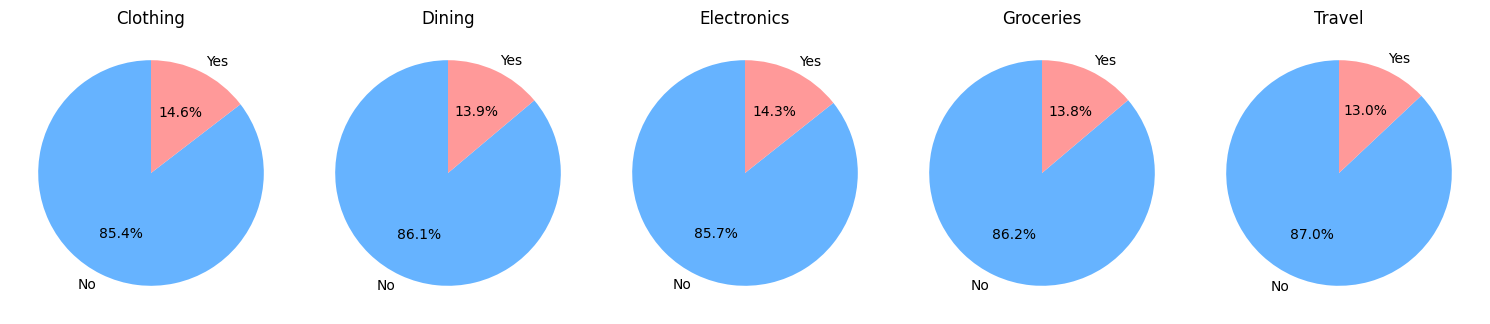

In [44]:
# Pie-chart for the categorial variable - Merchant Category

# Group by 'Merchant Category' and 'Fraud', and count the occurrences
fraud_counts = df.groupby(['Merchant Category', 'Fraud']).size().unstack(fill_value=0)

# Plot pie charts for each Merchant Category
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))
axes = axes.flatten()

for i, (job_role, counts) in enumerate(fraud_counts.iterrows()):
    counts.plot.pie(ax=axes[i], autopct='%1.1f%%', startangle=90, labels=['No', 'Yes'], colors=['#66b3ff', '#ff9999'])
    axes[i].set_title(job_role)
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()


In [37]:
# test whether the difference of yes answer rate in each 'Merchant Category' is statistically significant

import scipy.stats as stats

# Create a contingency table
contingency_table = pd.crosstab(df['Merchant Category'], df['Fraud'])

# Perform Chi-Square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Display the results
chi2, p

(2.422844794447375, 0.6585028234725516)

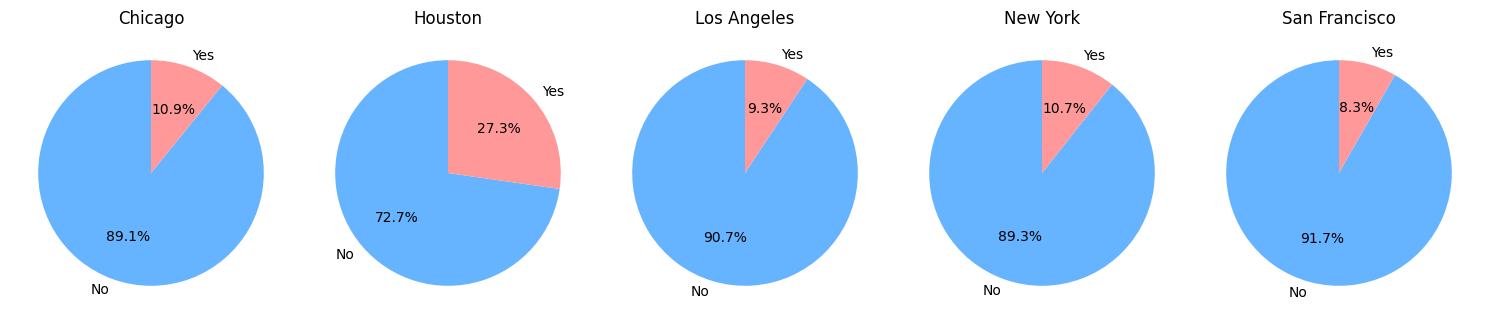

In [42]:
# Pie-chart for the categorial variable - Location

# Group by 'Location' and 'Fraud', and count the occurrences
fraud_counts = df.groupby(['Location', 'Fraud']).size().unstack(fill_value=0)

# Plot pie charts for each Location
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))
axes = axes.flatten()

for i, (job_role, counts) in enumerate(fraud_counts.iterrows()):
    counts.plot.pie(ax=axes[i], autopct='%1.1f%%', startangle=90, labels=['No', 'Yes'], colors=['#66b3ff', '#ff9999'])
    axes[i].set_title(job_role)
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

In [39]:
# test whether the difference of yes answer rate in each 'Location' is statistically significant
# Create a contingency table for 'Location' and 'Fraud'
contingency_table_dept = pd.crosstab(df['Location'], df['Fraud'])

# Perform Chi-Square test
chi2_dept, p_dept, dof_dept, expected_dept = stats.chi2_contingency(contingency_table_dept)

# Display the results
chi2_dept, p_dept

(469.5569492557882, 2.567486407847484e-100)

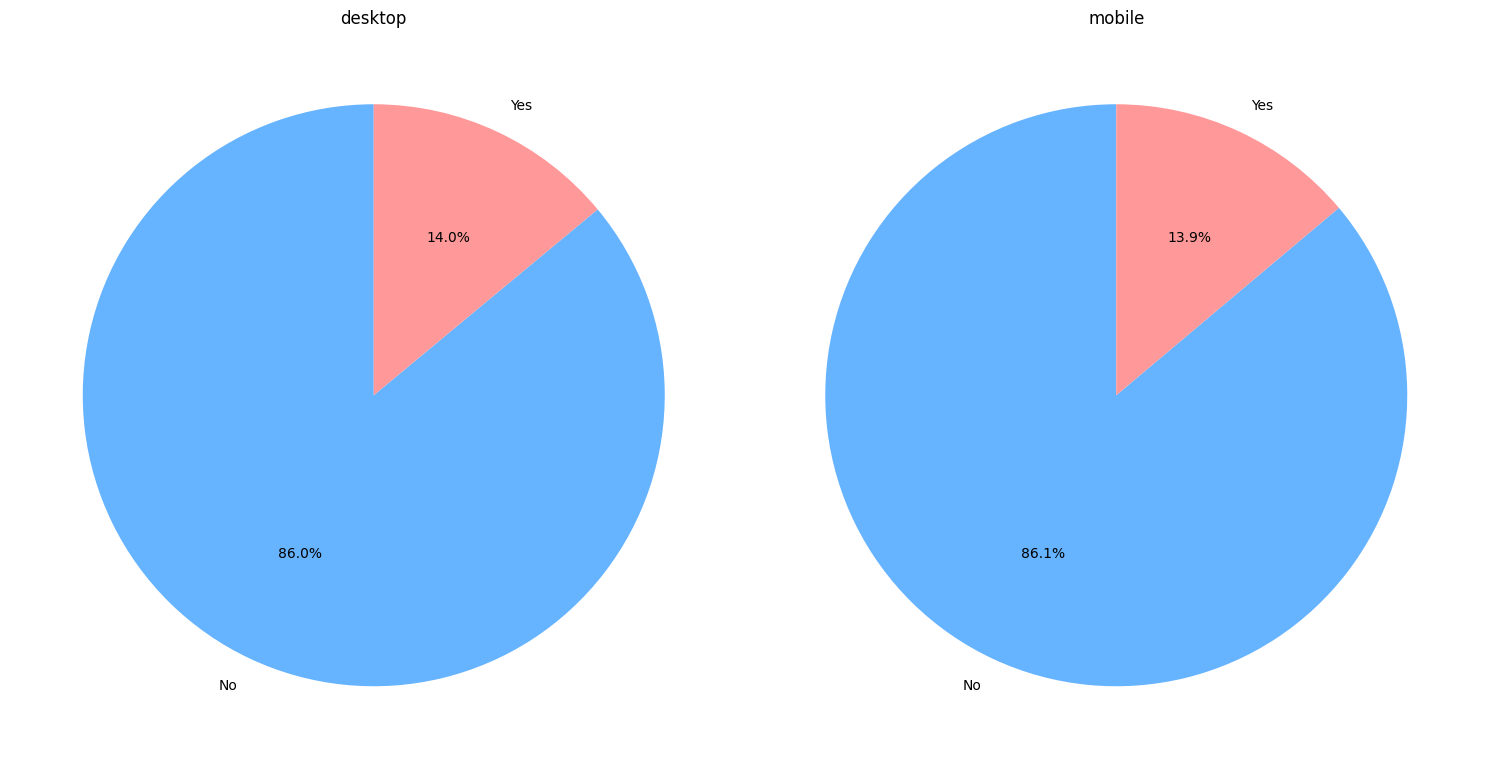

In [41]:
# Pie-chart for the categorial variable - Device Type

# Group by 'Device Type' and 'Fraud', and count the occurrences
fraud_counts = df.groupby(['Device Type', 'Fraud']).size().unstack(fill_value=0)

# Plot pie charts for each Device Type
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes = axes.flatten()

for i, (job_role, counts) in enumerate(fraud_counts.iterrows()):
    counts.plot.pie(ax=axes[i], autopct='%1.1f%%', startangle=90, labels=['No', 'Yes'], colors=['#66b3ff', '#ff9999'])
    axes[i].set_title(job_role)
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

In [45]:
# test whether the difference of yes answer rate in each 'Device Type' is statistically significant
# Create a contingency table for 'Device Type' and 'Fraud'
contingency_table_dept = pd.crosstab(df['Device Type'], df['Fraud'])

# Perform Chi-Square test
chi2_dept, p_dept, dof_dept, expected_dept = stats.chi2_contingency(contingency_table_dept)

# Display the results
chi2_dept, p_dept

(0.01652777685241005, 0.8977055011815493)

In [64]:
# Extract 'hour' & 'weekday' from 'Transaction Date and Time'
# day 0 = Monday
df['hour'] = df['Transaction Date and Time'].apply(lambda x: x.hour)
df['weekday'] = df['Transaction Date and Time'].apply(lambda x: x.weekday())

In [54]:
# define time_of_day
def time_of_day(x):
    if x >= 6 and x <= 10:
        return 'morning'
    elif x > 10 and x <= 14:
        return 'midday'
    elif x > 14 and x <= 18:
        return 'evening'
    elif x >18 and x <=22:
        return 'night'
    else:
        return 'afterhours'

df['time_of_day'] = df['hour'].apply(time_of_day)

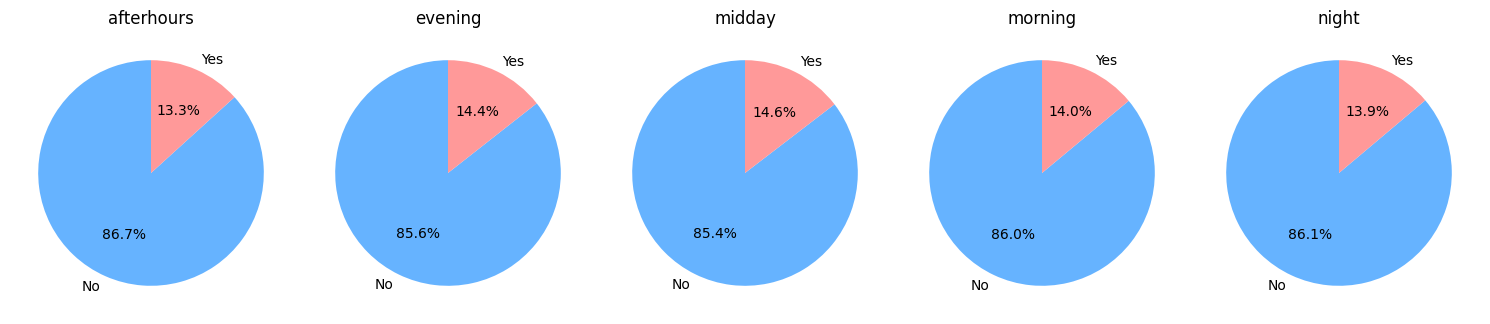

In [57]:
# Pie-chart for the categorial variable - time_of_day

# Group by 'time_of_day' and 'Fraud', and count the occurrences
fraud_counts = df.groupby(['time_of_day', 'Fraud']).size().unstack(fill_value=0)

# Plot pie charts for each Device Type
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))
axes = axes.flatten()

for i, (job_role, counts) in enumerate(fraud_counts.iterrows()):
    counts.plot.pie(ax=axes[i], autopct='%1.1f%%', startangle=90, labels=['No', 'Yes'], colors=['#66b3ff', '#ff9999'])
    axes[i].set_title(job_role)
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

In [55]:
# test whether the difference of yes answer rate in each ''time_of_day'' is statistically significant
# Create a contingency table for ''time_of_day'' and 'Fraud'
contingency_table_dept = pd.crosstab(df['time_of_day'], df['Fraud'])

# Perform Chi-Square test
chi2_dept, p_dept, dof_dept, expected_dept = stats.chi2_contingency(contingency_table_dept)

# Display the results
chi2_dept, p_dept

(1.98869487335604, 0.737838333073966)

In [53]:
# test whether the difference of yes answer rate in each 'weekday' is statistically significant
# Create a contingency table for 'weekday' and 'Fraud'
contingency_table_dept = pd.crosstab(df['weekday'], df['Fraud'])

# Perform Chi-Square test
chi2_dept, p_dept, dof_dept, expected_dept = stats.chi2_contingency(contingency_table_dept)

# Display the results
chi2_dept, p_dept

(6.546103729613736, 0.36486713591316433)

In [46]:
# Check for data imbalance in the 'Fraud' column
Fraud_counts = df['Fraud'].value_counts(normalize=True) * 100

# Display the results
Fraud_counts

Fraud
0    86.08
1    13.92
Name: proportion, dtype: float64

# Models

In [74]:
from sklearn.metrics import make_scorer, f1_score

# Define y and X
y = df['Fraud']
X = df[['Transaction Amount', 'Previous Transaction Amount', 
        'Time Since Last Transaction','Location']]

# Define numerical and categorical columns
numerical_cols = ['Transaction Amount', 'Previous Transaction Amount', 
                  'Time Since Last Transaction']
categorical_cols = ['Location']

# Create preprocessing pipelines
numerical_pipeline = Pipeline([
    ('scaler', MinMaxScaler())
])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine pipelines
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC()
}

# Cross-validation and evaluation
f1_scorer = make_scorer(f1_score)

for model_name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=f1_scorer)
    print(f"{model_name} - Cross-Validation F1 Score: {cv_scores.mean():.4f}")




Logistic Regression - Cross-Validation F1 Score: 0.6346
KNN - Cross-Validation F1 Score: 0.7216
Naive Bayes - Cross-Validation F1 Score: 0.5805
Decision Tree - Cross-Validation F1 Score: 0.5939
SVM - Cross-Validation F1 Score: 0.6594


In [75]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Define parameter grids for each model
param_grid_logreg = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga']
}

param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

param_grid_nb = {
    'classifier__var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03]
}

# Create pipelines for each model
pipelines = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000))
    ]),
    'KNN': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ]),
    'Naive Bayes': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GaussianNB())
    ])
}

# Define GridSearchCV for each model
grid_searches = {
    'Logistic Regression': GridSearchCV(pipelines['Logistic Regression'], param_grid_logreg, cv=5, scoring='f1', n_jobs=-1),
    'KNN': GridSearchCV(pipelines['KNN'], param_grid_knn, cv=5, scoring='f1', n_jobs=-1),
    'Naive Bayes': GridSearchCV(pipelines['Naive Bayes'], param_grid_nb, cv=5, scoring='f1', n_jobs=-1)
}

# Perform GridSearchCV for each model
best_params_grid = {}
for model_name, search in grid_searches.items():
    search.fit(X_train, y_train)
    best_params_grid[model_name] = search.best_params_
    print(f"{model_name} - Best Parameters: {search.best_params_}")
    best_score = search.best_score_
    print(f"{model_name} - Best Cross-Validation F1 Score: {best_score:.4f}")




Logistic Regression - Best Parameters: {'classifier__C': 100, 'classifier__solver': 'saga'}
Logistic Regression - Best Cross-Validation F1 Score: 0.6563
KNN - Best Parameters: {'classifier__n_neighbors': 7, 'classifier__p': 2, 'classifier__weights': 'uniform'}
KNN - Best Cross-Validation F1 Score: 0.7262
Naive Bayes - Best Parameters: {'classifier__var_smoothing': 0.001}
Naive Bayes - Best Cross-Validation F1 Score: 0.5808


In [88]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Initialize the models with the best parameters
best_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='liblinear', C=10),
    'KNN': KNeighborsClassifier(weights='distance', p=2, n_neighbors=7),
    'Naive Bayes': GaussianNB(var_smoothing=1e-09)
}

# Train and evaluate each model
evaluation_results = {}

for model_name, model in best_models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, "predict_proba") else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred,)
    roc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    
    evaluation_results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC Score': roc
    }
    
    # Display the evaluation results for the model
    print(f"{model_name} Evaluation Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if roc is not None:
        print(f"ROC AUC Score: {roc:.4f}")
    else:
        print("ROC AUC Score: N/A")

# Display all evaluation results
print(evaluation_results)

Logistic Regression Evaluation Results:
Accuracy: 0.9280
Precision: 0.9299
Recall: 0.4975
F1 Score: 0.6482
ROC AUC Score: 0.8278
KNN Evaluation Results:
Accuracy: 0.9390
Precision: 0.9094
Recall: 0.6025
F1 Score: 0.7248
ROC AUC Score: 0.8296
Naive Bayes Evaluation Results:
Accuracy: 0.8877
Precision: 0.5854
Recall: 0.5400
F1 Score: 0.5618
ROC AUC Score: 0.8036
{'Logistic Regression': {'Accuracy': 0.928, 'Precision': 0.9299065420560748, 'Recall': 0.4975, 'F1 Score': 0.6482084690553745, 'ROC AUC Score': 0.8277538461538461}, 'KNN': {'Accuracy': 0.939, 'Precision': 0.909433962264151, 'Recall': 0.6025, 'F1 Score': 0.724812030075188, 'ROC AUC Score': 0.8295927884615385}, 'Naive Bayes': {'Accuracy': 0.8876666666666667, 'Precision': 0.5853658536585366, 'Recall': 0.54, 'F1 Score': 0.5617685305591678, 'ROC AUC Score': 0.8036490384615385}}


<Figure size 640x480 with 0 Axes>

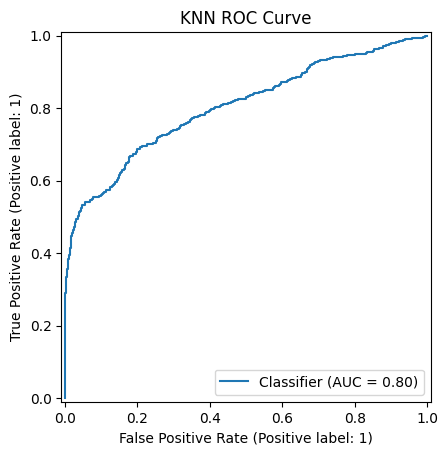

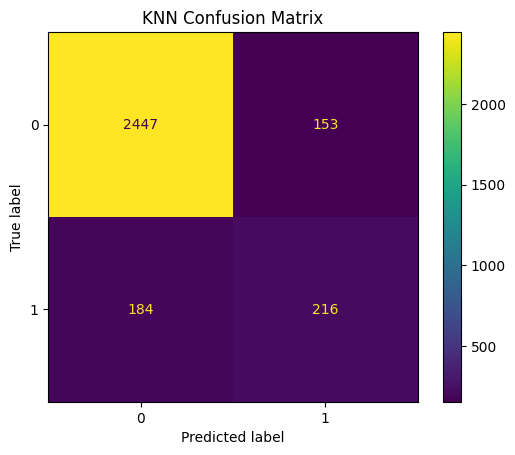

KNN Classification Report:
              precision    recall  f1-score   support

    No Fraud       0.93      0.94      0.94      2600
       Fraud       0.59      0.54      0.56       400

    accuracy                           0.89      3000
   macro avg       0.76      0.74      0.75      3000
weighted avg       0.88      0.89      0.89      3000



In [89]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Extract KNN model from the pipeline
knn_model = best_models['KNN']

# Calculate probabilities for ROC curve
y_prob_knn = pipeline.predict_proba(X_test)[:, 1]

# Plot ROC curve
plt.figure()
RocCurveDisplay.from_predictions(y_test, y_prob_knn)
plt.title('KNN ROC Curve')
plt.show()

# Generate confusion matrix plot
y_pred_knn = pipeline.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_knn)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.title('KNN Confusion Matrix')
plt.show()

# Generate and print classification report
class_report = classification_report(y_test, y_pred_knn, target_names=['No Fraud', 'Fraud'])
print("KNN Classification Report:")
print(class_report)


Decision Tree - Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 4, 'classifier__max_features': None, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'classifier__splitter': 'best'}
Decision Tree - Best Cross-Validation F1 Score: 0.7111
Decision Tree Evaluation Scores:
Accuracy: 0.9343
Precision: 0.9394
Recall: 0.5425
F1 Score: 0.6878
ROC AUC Score: 0.8220


c:\Users\NeilXu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
360 fits failed out of a total of 1440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
174 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\NeilXu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\NeilXu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\NeilX

<Figure size 640x480 with 0 Axes>

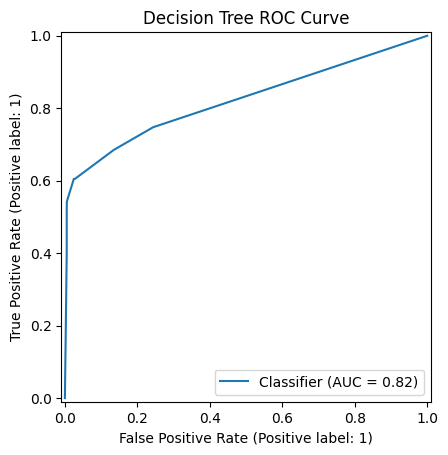

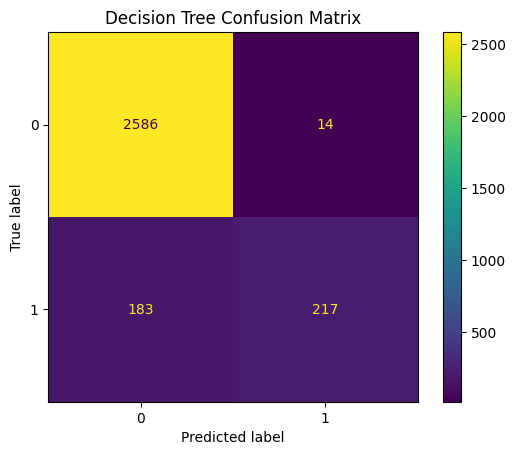

Decision Tree Classification Report:
              precision    recall  f1-score   support

    No Fraud       0.93      0.99      0.96      2600
       Fraud       0.94      0.54      0.69       400

    accuracy                           0.93      3000
   macro avg       0.94      0.77      0.83      3000
weighted avg       0.93      0.93      0.93      3000



In [90]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define parameter grid for Decision Tree
param_grid_dt = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__splitter': ['best', 'random'],
    'classifier__max_depth': [3,4],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': [None, 'auto', 'sqrt', 'log2']
}

# Create pipeline for Decision Tree
pipeline_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Define GridSearchCV for Decision Tree
grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=5, scoring='f1', n_jobs=-1)

# Perform GridSearchCV
grid_search_dt.fit(X_train, y_train)

# Get the best model
dt_best = grid_search_dt.best_estimator_
print(f"Decision Tree - Best Parameters: {grid_search_dt.best_params_}")
print(f"Decision Tree - Best Cross-Validation F1 Score: {grid_search_dt.best_score_:.4f}")

# Make predictions
y_pred_dt = dt_best.predict(X_test)
y_prob_dt = dt_best.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
roc_dt = roc_auc_score(y_test, y_prob_dt)

# Print evaluation scores
print("Decision Tree Evaluation Scores:")
print(f"Accuracy: {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall: {recall_dt:.4f}")
print(f"F1 Score: {f1_dt:.4f}")
print(f"ROC AUC Score: {roc_dt:.4f}")

# Plot ROC curve
plt.figure()
RocCurveDisplay.from_predictions(y_test, y_prob_dt)
plt.title('Decision Tree ROC Curve')
plt.show()

# Plot confusion matrix
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
ConfusionMatrixDisplay(conf_matrix_dt).plot()
plt.title('Decision Tree Confusion Matrix')
plt.show()

# Print classification report
class_report_dt = classification_report(y_test, y_pred_dt, target_names=['No Fraud', 'Fraud'])
print("Decision Tree Classification Report:")
print(class_report_dt)


In [105]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Initialize the models with the best parameters
best_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='liblinear', C=10),
    'KNN': KNeighborsClassifier(weights='distance', p=2, n_neighbors=7),
    'Naive Bayes': GaussianNB(var_smoothing=1e-09)
}

# Train and evaluate each model
evaluation_results = {}

for model_name, model in best_models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, "predict_proba") else None
    threshold = 0.49
    y_pred = (y_prob >= threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred,)
    roc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    
    evaluation_results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC Score': roc
    }
    
    # Display the evaluation results for the model
    print(f"{model_name} Evaluation Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if roc is not None:
        print(f"ROC AUC Score: {roc:.4f}")
    else:
        print("ROC AUC Score: N/A")

# Display all evaluation results
print(evaluation_results)

Logistic Regression Evaluation Results:
Accuracy: 0.9287
Precision: 0.9306
Recall: 0.5025
F1 Score: 0.6526
ROC AUC Score: 0.8278
KNN Evaluation Results:
Accuracy: 0.9387
Precision: 0.9030
Recall: 0.6050
F1 Score: 0.7246
ROC AUC Score: 0.8296
Naive Bayes Evaluation Results:
Accuracy: 0.8857
Precision: 0.5760
Recall: 0.5400
F1 Score: 0.5574
ROC AUC Score: 0.8036
{'Logistic Regression': {'Accuracy': 0.9286666666666666, 'Precision': 0.9305555555555556, 'Recall': 0.5025, 'F1 Score': 0.6525974025974026, 'ROC AUC Score': 0.8277538461538461}, 'KNN': {'Accuracy': 0.9386666666666666, 'Precision': 0.9029850746268657, 'Recall': 0.605, 'F1 Score': 0.7245508982035929, 'ROC AUC Score': 0.8295927884615385}, 'Naive Bayes': {'Accuracy': 0.8856666666666667, 'Precision': 0.576, 'Recall': 0.54, 'F1 Score': 0.5574193548387096, 'ROC AUC Score': 0.8036490384615385}}
